# <span style='background:blue'>  <span style="color:orange"> ***Reviewer Note:*** **Begin PEP8 check cells (delete below when finished)**</span> </span>

In [1]:
# disable all imported packages' loggers
import logging
logging.root.manager.loggerDict = {}

In [2]:
%load_ext pycodestyle_magic
%flake8_on --ignore E261,E501,W291,W293

# only allow the checker to throw warnings when there's a violation
logging.getLogger('flake8').setLevel('ERROR')
logging.getLogger('stpipe').setLevel('ERROR')

# <span style='background:blue'>  <span style="color:orange"> ***Reviewer Note:*** **End PEP8 check cells (delete above when finished)**</span> </span>

In [3]:
from fastai.basics import *
from fastai.vision.all import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

from astropy.io import fits

rng = np.random.RandomState(256)

1:1: F403 'from fastai.basics import *' used; unable to detect undefined names
2:1: F403 'from fastai.vision.all import *' used; unable to detect undefined names
7: F405 'np' may be undefined, or defined from star imports: fastai.basics, fastai.vision.all


## Use noisy simulated data set

In [4]:
!wget --no-clobber https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-noisy.fits

File ‘hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-noisy.fits’ already there; not retrieving.



In [5]:
with fits.open('hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-noisy.fits') as h:
    X_pristine = h[0].data
    y_pristine = h[1].data

In [6]:
X = tensor(np.asarray(X_pristine).astype('float32'))
y = tensor(np.asarray(y_pristine).astype('float32'))

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=rng, shuffle=True)

In [8]:
image_means = X_train[:100].mean(dim=(0, 2, 3))
image_stds = X_train[:100].std(dim=(0, 2, 3))

In [9]:
transforms_train = Pipeline([ToTensor, Dihedral, Normalize.from_stats(image_means, image_stds)])
transforms_valid = Pipeline([ToTensor, Normalize.from_stats(image_means, image_stds)])

In [10]:
class GalaxyDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target.type(torch.LongTensor) # <-- make sure you cast this...
        self.transform = transform
        
        self.c = len(np.unique(target))
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [11]:
dset_train = GalaxyDataset(X_train, y_train, transform=transforms_train)
dset_valid = GalaxyDataset(X_valid, y_valid, transform=transforms_valid)

In [12]:
def norm(vals, vmin=None, vmax=None, Q=8, stretch=None):
    """
    For visualization purposes normalize image with `arcsinh((vals-vmin)/(vmax-vmin)), 
    with vmin and vmax respectively defaulted to 0.01 and 0.99 quantiles of all values. 
    
    Q and stretch control the arcsinh softening parameter, see Lupton et al. 2004 and
    see https://docs.astropy.org/en/stable/_modules/astropy/visualization/lupton_rgb.html#make_lupton_rgb
    """
    if vmin is None: vmin = np.quantile(vals, 0.01)
    if vmax is None: vmax = np.quantile(vals, 0.99)
    
    if stretch is None:
        return np.arcsinh(Q*(vals - vmin) / (vmax-vmin)) / Q
    else:
        return np.arcsinh(Q*(vals - vmin) / stretch) / Q

9:20: E701 multiple statements on one line (colon)
10:20: E701 multiple statements on one line (colon)


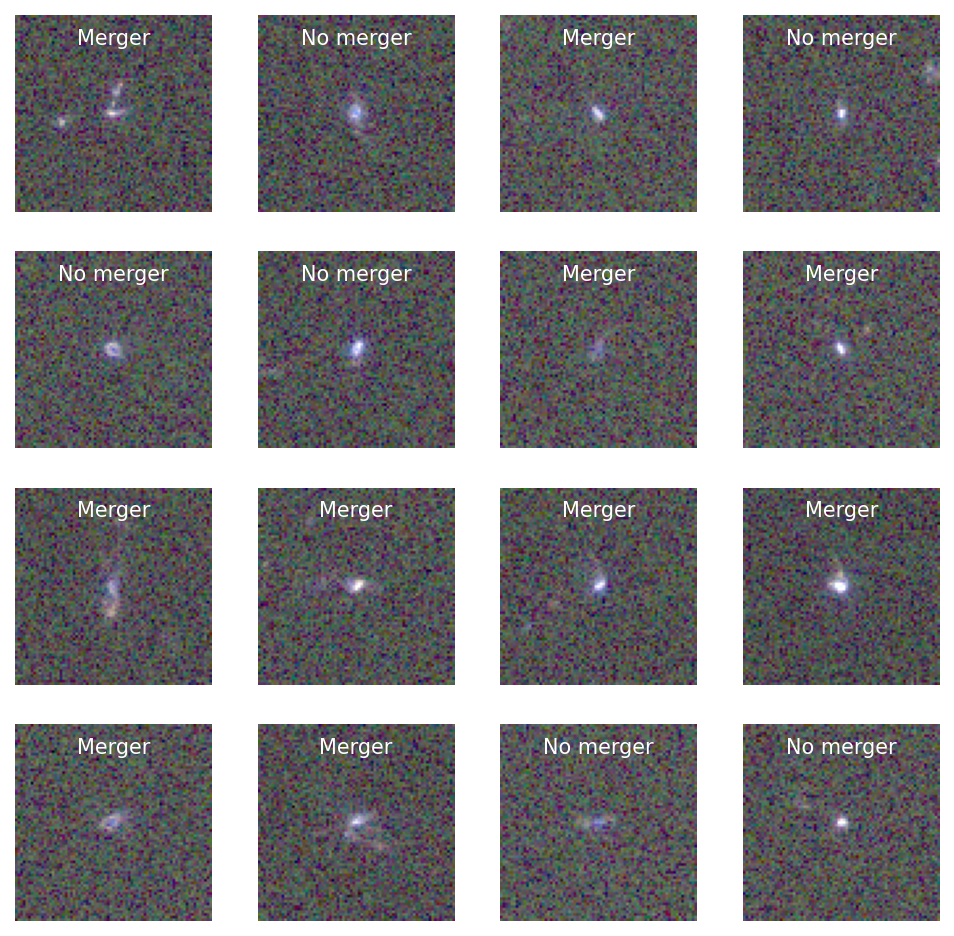

In [13]:
fig = plt.figure(figsize=(8, 8), dpi=150) 

for i, (image, cls) in enumerate(zip(*dset_train[:16])):
    ax = fig.add_subplot(4, 4, i+1)
    
    image = norm(image, Q=4).permute(1, 2, 0).clip(0, 1)

    ax.imshow(image, aspect='equal')
    ax.text(0.5, 0.85, "Merger" if cls == 1 else "No merger", ha='center', color='white', transform=ax.transAxes)
    
    ax.axis('off')
    
plt.show()

## Train using standard resnet18

In [14]:
dls = ImageDataLoaders.from_dsets(dset_train, dset_valid, device='cuda', bs=64)

In [15]:
model = resnet18()
model.fc = nn.Linear(in_features=512, out_features=dls.c, bias=True)

learn = Learner(
    dls, 
    model, 
    loss_func=CrossEntropyLossFlat(), 
    opt_func=Adam,
    metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()]
)

learn.cuda();

AssertionError: Torch not compiled with CUDA enabled

12:13: E703 statement ends with a semicolon


In [ ]:
learn.fit(5, 1e-2)

## Evaluate results via confusion matrix

In [ ]:
ps, ys = learn.get_preds()

ps = ps[:, 1].flatten().detach().numpy()
ys = ys.flatten().detach().numpy()

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    ys, 
    ps > 0.5, 
    cmap='Blues', 
    normalize='true', 
    display_labels=['No merger', 'Merger']
);

## Repeat using the hybrid deconvolution approach presented in [Wu & Peek 2020](https://ar5iv.labs.arxiv.org/html/2009.12318)

You can download the original code here: https://github.com/jwuphysics/predicting-spectra-from-images

or use the streamlined version here: https://github.com/jwuphysics/deepmerge

In [ ]:
!git clone https://github.com/jwuphysics/deepmerge.git

In [ ]:
import sys
sys.path.append(f'deepmerge/src')
from xresnet_hybrid import xresnet18_hybrid

In [ ]:
model = xresnet18_hybrid(act_cls=Mish, sa=True, n_out=dls.c)

learn = Learner(
    dls, 
    model, 
    loss_func=CrossEntropyLossFlat(), 
    opt_func=Adam,
    metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()]
)

learn.cuda();

In [ ]:
learn.fit(5, 1e-2)

In [ ]:
ps, ys = learn.get_preds()

ps = ps[:, 1].flatten().detach().numpy()
ys = ys.flatten().detach().numpy()

ConfusionMatrixDisplay.from_predictions(
    ys, 
    ps > 0.5, 
    cmap='Blues', 
    normalize='true', 
    display_labels=['No merger', 'Merger']
);